In [5]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', None)

os.chdir('E:\\Python\\HousesPricing')

### House Prices: Advanced Regression Techniques

In [6]:

def checkDAta(data):
    colsWitNa = []
    for i in range(0, len(data.columns)):
        if data[data.columns[i]].isnull().values.any():
            colsWitNa.extend([data.columns[i]])
    print (colsWitNa)

    
def Error(y, y_pred):
    return(np.mean(abs(y-y_pred)/y))

def rmse(y, y_pred):
    return (np.sqrt(((y-y_pred) ** 2).mean()))


Import data train.csv and test.csv

In [7]:
train= pd.read_csv("train.csv")
test= pd.read_csv("test.csv")
data= pd.concat([train, test], axis=0)

data.loc[(data.PoolQC.isnull()) & (data.PoolArea==0), "PoolQC"]= "None"
temp = data[data.PoolQC.isnull()]
cat= temp.PoolArea.unique()
catmeans= data[["PoolArea", "PoolQC"]].groupby("PoolQC", as_index=False).mean()
for i in range(0, len(cat)):
    tt= data[(data.PoolQC.isnull()) & (data.PoolArea==cat[i])][["PoolArea", "PoolQC"]]
    catmeans["Diff"]= (catmeans.PoolArea- tt.PoolArea.iloc[0]).abs()
    replaceCat= catmeans.PoolQC[catmeans.Diff==catmeans.Diff.min()].iloc[0]
    data.loc[(data.PoolQC.isnull()) & (data.PoolArea == cat[i]), "PoolQC"]= replaceCat

data= data[list(train.columns)]

In [8]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706.0,Unf,0.0,150.0,856.0,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2.0,548.0,TA,TA,Y,0,61,0,0,0,0,None,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978.0,Unf,0.0,284.0,1262.0,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2.0,460.0,TA,TA,Y,298,0,0,0,0,0,None,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486.0,Unf,0.0,434.0,920.0,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2.0,608.0,TA,TA,Y,0,42,0,0,0,0,None,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216.0,Unf,0.0,540.0,756.0,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3.0,642.0,TA,TA,Y,0,35,272,0,0,0,None,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655.0,Unf,0.0,490.0,1145.0,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3.0,836.0,TA,TA,Y,192,84,0,0,0,0,None,NaN,NaN,0,12,2008,WD,Normal,250000.0


Let`s visualize missing values of our data set usind three dimensional array RGB.

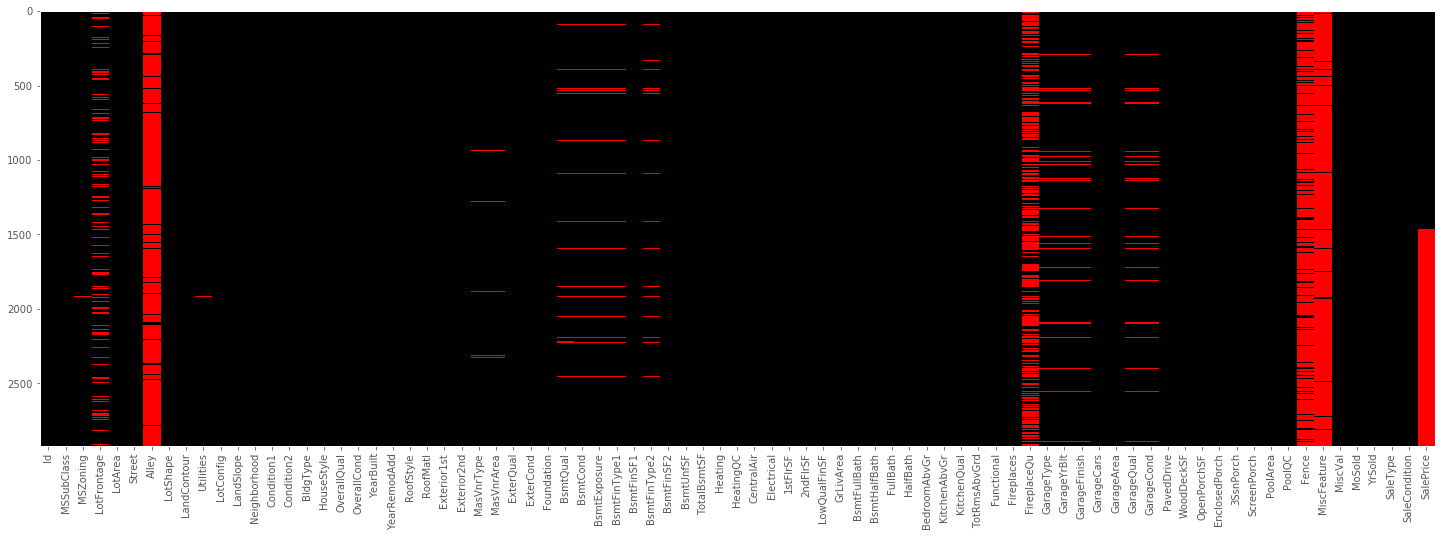

In [9]:
###Prepare data for visualize missing values
dataHeatMap= data.copy()
table = np.ones((dataHeatMap.shape[0], dataHeatMap.shape[1], 3), dtype=np.uint8) * 0

col= dataHeatMap.columns
for i in range(0, len(col)):
    dataHeatMap.loc[~dataHeatMap[col[i]].isnull(), col[i]]=0
dataHeatMap= dataHeatMap.fillna(255)
dataHeatMap= dataHeatMap.values.tolist()

for i in range(0, len(dataHeatMap)):
    table[i, :, 0]= dataHeatMap[i]
    
style.use('ggplot')
f = plt.figure(figsize=(25, 8))
plt.imshow(table, interpolation='none', aspect='auto')
plt.xticks(range(table.shape[1]), data.columns, rotation='vertical')
plt.grid(False)
plt.show()

Let`s fill all missing values for each feachure, using different techniques.

In [10]:
###Fill missing values
data.loc[data.MSZoning.isnull(), "MSZoning"]= data.MSZoning.value_counts().index[0]
data.loc[data.LotFrontage.isnull(), "LotFrontage"]= data.LotFrontage[data.Street=="Pave"].median()
data.loc[data.Alley.isnull(), "Alley"]= "None"
data.loc[data.Utilities.isnull(), "Utilities"]= data.Utilities.value_counts().index[0]
data.loc[data.Exterior1st.isnull(), "Utilities"]= data.Exterior1st.value_counts().index[0]
data.loc[data.Exterior2nd.isnull(), "Utilities"]= data.Exterior2nd.value_counts().index[0]

data.loc[(data.MasVnrType.isnull()) & (data.MasVnrArea.isnull()), "MasVnrType"]= "None"
data.loc[(data.MasVnrArea.isnull()), "MasVnrArea"]= 0
data.loc[(data.MasVnrType.isnull()) & (~data.MasVnrArea.isnull()), "MasVnrType"]= "Stone"

data.loc[(data.BsmtQual.isnull()) & (data.BsmtCond=="Fa"),  "BsmtQual"]= "TA"
data.loc[(data.BsmtQual.isnull()) & (data.BsmtCond=="TA"),  "BsmtQual"]= "TA"
#data= data.dropna(subset=["BsmtFinType1", "BsmtFinSF2", "BsmtFinType2", "BsmtFinSF2", "BsmtUnfSF"])
data.loc[data.BsmtFinSF2.isnull(), "BsmtFinSF2"]= data.BsmtFinSF2.median()
data.loc[data.BsmtUnfSF.isnull(), "BsmtUnfSF"]= data.BsmtUnfSF.median()
data.loc[data.TotalBsmtSF.isnull(), "TotalBsmtSF"]= data.TotalBsmtSF.median()
data.loc[(data.BsmtFinType1.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()),"BsmtFinType1"]= "None"
data.loc[(data.BsmtFinType2.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()),"BsmtFinType2"]= "None"
data.loc[(data.BsmtFinType2.isnull()) & (data.BsmtCond=="TA") & (data.BsmtExposure=="No") & (data.BsmtFinType1=="GLQ"),"BsmtFinType2"]= \
    data.loc[ (data.BsmtCond=="TA") & (data.BsmtExposure=="No") & (data.BsmtFinType1=="GLQ")].BsmtFinType2.value_counts().index[0]
#data.loc[(data.BsmtFinSF2.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()),"BsmtFinSF2"]= "None"
#data.loc[(data.BsmtUnfSF.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()),"BsmtUnfSF"]= "None"
#data.loc[(data.TotalBsmtSF.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()),"TotalBsmtSF"]= "None"
data.loc[(data.BsmtQual=="Gd") & (data.BsmtCond.isnull()), "BsmtCond"]= data[data.BsmtQual=="Gd"].BsmtCond.value_counts().index[0]
data.loc[(data.BsmtQual=="TA") & (data.BsmtCond.isnull()), "BsmtCond"]= data[data.BsmtQual=="TA"].BsmtCond.value_counts().index[0]
data.loc[(data.BsmtQual.isnull()) & (data.BsmtCond.isnull()) & (data.BsmtExposure.isnull()), ["BsmtQual", "BsmtCond", "BsmtExposure"]]= "None"
#data.loc[data.BsmtFinType2.isnull(), "BsmtFinType2"]= data[(data.BsmtQual=="Gd") & (data.BsmtCond=="TA") & (data.BsmtExposure=="No") & (data.BsmtFinType1=="GLQ")].BsmtFinType2.value_counts().index[0]
data.loc[data.BsmtExposure.isnull(), "BsmtExposure"]= "None"
data.loc[data.BsmtFinSF1.isnull(), "BsmtFinSF1"]= data.BsmtFinSF1.median()

#data.loc[data.Electrical.isnull(), "Alley"]= "None"

data.loc[data.BsmtFullBath.isnull(), "BsmtFullBath"]= data.BsmtFullBath.value_counts().index[0]
data.loc[data.BsmtHalfBath.isnull(), "BsmtHalfBath"]= data.BsmtHalfBath.value_counts().index[0]

data.loc[data.KitchenQual.isnull(), "KitchenQual"]= data[data.KitchenAbvGr==1].KitchenQual.value_counts().index[0]

data.loc[data.Functional.isnull(), "Functional"]= data.Functional.value_counts().index[0]

data.loc[data.FireplaceQu.isnull(), "FireplaceQu"]= "None"

data.loc[data.GarageArea==0, "GarageType"]= "None"
#data.loc[data.GarageCars==0, "GarageType"]= "None"
data.loc[data.GarageType.isnull(), "GarageType"]= "None"
data.loc[data.GarageArea.isnull(), "GarageArea"]= data[data.GarageType=="Detchd"].GarageYrBlt.value_counts().index[0]
data.loc[data.Exterior1st.isnull(), "Exterior1st"]= data.Exterior1st.value_counts().index[0]
data.loc[data.Exterior2nd.isnull(), "Exterior2nd"]= data.Exterior2nd.value_counts().index[0]
#data.loc[data.MasVnrType.isnull(), "MasVnrType"]= data.MasVnrArea[data.MasVnrType=="Stone"].mean()
#data.loc[data.MasVnrType=="None", "MasVnrArea"]= "None"
data.loc[data.Electrical.isnull(), "Electrical"]= data.Electrical.value_counts().index[0]
data.loc[data.GarageType=="None", "GarageYrBlt"]= "None"
data.loc[data.GarageType=="None", "GarageFinish"]= "None"

data.loc[(data.GarageType=="Detchd") & (data.GarageYrBlt.isnull()), "GarageYrBlt"]= int(data[(data.GarageType=="Detchd")].GarageYrBlt.median())
data.loc[(data.GarageType=="Detchd") & (data.GarageFinish.isnull()), "GarageFinish"]= data[(data.GarageType=="Detchd")].GarageFinish.value_counts().index[0]
data.loc[data.GarageCars.isnull(), "GarageCars"]= int(round(data[(data.GarageType=="Detchd") & (data.GarageFinish=="Unf") ].GarageCars.median()))
data.loc[data.GarageType=="None", "GarageQual"]= "None"
data.loc[(data.GarageType=="Detchd") & (data.GarageYrBlt==1961) & (data.GarageFinish=="Unf"), "GarageQual"]= data[(data.GarageType=="Detchd") & (data.GarageYrBlt==1961) & (data.GarageFinish=="Unf") & (~data.GarageQual.isnull())].GarageQual.value_counts().index[0]
data.loc[data.GarageCond.isnull(), "GarageCond"]= data[(data.GarageType=="Detchd") & (data.GarageYrBlt==1961) & (data.GarageFinish=="Unf") & (~data.GarageCond.isnull()) ].GarageCond.value_counts().index[0]
data.loc[(data.GarageCars==1) & (data.GarageCond=="TA") & (data.GarageFinish=="Unf") & (data.GarageYrBlt==1962) & (data.GarageQual.isnull()), "GarageQual"]= 0

data.loc[data.Fence.isnull(), "Fence"]= "None"
data.loc[data.MiscFeature.isnull(), "MiscFeature"]= "None"

data.loc[data.SaleType.isnull(), "SaleType"]= data.SaleType.value_counts().index[0]


Create and add new features.

Simplifications of existing features

Combinations of existing features

Polynomials on the top n existing features

In [11]:
###Add new variables
# add total area
cols= ["MasVnrArea", "BsmtFinSF1", "BsmtFinSF2", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", \
       "GrLivArea", "GarageArea", "OpenPorchSF", "3SsnPorch", "EnclosedPorch", "ScreenPorch", "WoodDeckSF"]
totalArea= 0
for i in cols:
    totalArea= totalArea + data[i].astype(int)

data["IsGarage"]= (~(data.GarageType=="None")*1).astype(object)
cols= ["IsGarage", "FullBath", "BsmtFullBath", "BsmtHalfBath", "HalfBath"]
totalRoms= 0
for i in cols:
    totalRoms= totalRoms + data[i].fillna(0)

data["TotalArea"]= totalArea.astype(object)
data["TotalRooms"]= totalRoms.astype(object)


data["IsRegularLotShape"] = ((data["LotShape"] == "Reg") * 1).astype(object)
data["IsAlley"] = ((data["Alley"] != "None") * 1).astype(object)
data["IsMSZoningRL"] = ((data["MSZoning"] == "RL") * 1).astype(object)
data["IsLandSlopeGtl"] = ((data["LandSlope"] == "Gtl") * 1).astype(object)
data["Remodeled"] = ((data["YearRemodAdd"] != data["YearBuilt"]) * 1).astype(object)
data["RecentRemodel"] = ((data["YearRemodAdd"] == data["YrSold"]) * 1).astype(object)
data["IsBsmtCondTa"] = ((data["BsmtCond"] == "TA") * 1).astype(object)
data["IsBsmtFinType2Unf"] = ((data["BsmtFinType2"] == "Unf") * 1).astype(object)
data["IsHeatingGasA"] = ((data["Heating"] == "GasA") * 1).astype(object)
data["VeryNewHouse"] = ((data["YearBuilt"] == data["YrSold"]) * 1).astype(object)
data["IsFireplaces"] = ((data["Fireplaces"] >0) * 1).astype(object)
data["IsPavedDrivePaved"] = ((data["PavedDrive"] == "Y") * 1).astype(object)
data["HasWoodDeck"] = ((data["WoodDeckSF"] == 0) * 1).astype(object)
data["Hs2Floor"] = ((data["2ndFlrSF"] > 0) * 1).astype(object)
data["SoldAtYrBuild"]= ((data.YearBuilt==data.YrSold)*1).astype(object)
data["HighSeason"] = (data["MoSold"].replace( {1: 0, 2: 0, 3: 0, 4: 0, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0})).astype(object)
data["YearsSinceRemodel"] = (data["YrSold"] - data["YearRemodAdd"]).astype(object)
data["Age"] = (2010 - data["YearBuilt"]).astype(object)
data["TotalBath"]= (data.BsmtFullBath+data.BsmtHalfBath+data.FullBath+data.HalfBath).astype(int)
data["IsBath"]= ((data.TotalBath>0)*1).astype(object)
data["IsCars"]= ((data.GarageCars>0)*1).astype(object)

data["Is2ndFloor"] = ((data["2ndFlrSF"] == 0) * 1).astype(object)
data["IsMasVnr"] = ((data["MasVnrArea"] == 0) * 1).astype(object)
data["IsWoodDeck"] = ((data["WoodDeckSF"] == 0) * 1).astype(object)
data["IsOpenPorch"] = ((data["OpenPorchSF"] == 0) * 1).astype(object)
data["IsEnclosedPorch"] = ((data["EnclosedPorch"] == 0) * 1).astype(object)
data["Is3SsnPorch"] = ((data["3SsnPorch"] == 0) * 1).astype(object)
data["IsScreenPorch"] = ((data["ScreenPorch"] == 0) * 1).astype(object)

#data["IsPool"]= ((data.PoolArea>0)*1).astype(object)
#ata["IsFence"]= ((data.Fence!="None")*1).astype(object)
#data["IsBsmt"]= ((data.BsmtQual!="None")*1).astype(object)

data.MoSold= data.MoSold.astype(object)
data.YrSold= data.YrSold.astype(object)


In [12]:
data.MasVnrArea= data.MasVnrArea.astype(int)
data.GarageCars= data.GarageCars.astype(int)
data.GarageArea= data.GarageArea.astype(int)
data.BsmtFinSF1= data.BsmtFinSF1.astype(int)
data.TotalBsmtSF= data.TotalBsmtSF.astype(int)
data.BsmtUnfSF= data.BsmtUnfSF.astype(int)
data.BsmtFinSF2= data.BsmtFinSF2.astype(int)
data.MasVnrArea= data.MasVnrArea.astype(int)
data.LotFrontage= data.LotFrontage.astype(int)
data.TotalArea= data.TotalArea.astype(int)
data.TotalRooms= data.TotalRooms.astype(int)
data.Age= data.Age.astype(int)
data.YearsSinceRemodel= data.YearsSinceRemodel.astype(int)
data.HighSeason= data.HighSeason.astype(int)
data.GrLivArea= data.GrLivArea.astype(int)
data['1stFlrSF']= data['1stFlrSF'].astype(int)
data["2ndFlrSF"]= data["2ndFlrSF"].astype(int)
data.OpenPorchSF= data.OpenPorchSF.astype(int)
data.WoodDeckSF= data.WoodDeckSF.astype(int)
data.FullBath= data.FullBath.astype(int)
data.HalfBath= data.HalfBath.astype(int)
data["SeasonSold"] = data["MoSold"].map({12:0, 1:0, 2:0, 3:1, 4:1, 5:1, 6:2, 7:2, 8:2, 9:3, 10:3, 11:3}).astype(int)

#data.PavedDrive= data.PavedDrive.astype(int)

In [13]:
data.GarageYrBlt= data.GarageYrBlt.astype(str)
data.GarageYrBlt[data.GarageYrBlt>"2010"]= "2010"
data.GarageYrBlt= data.GarageYrBlt.astype(float).astype(int)
data["GarageOld"]= "old"
data.GarageOld[(data.GarageYrBlt>1920)]= "medium"
data.GarageOld[(data.GarageYrBlt>1995)]= "new"

data["HouseOld"]= "old"
data.HouseOld[data.Age>60]= "medium"
data.HouseOld[data.Age>20]= "new"

In [14]:
# Feature for neighborhood. Create groups for neighborhood
train= data[~data.SalePrice.isnull()]
neighbor= train[["Neighborhood", "SalePrice"]].groupby("Neighborhood", as_index=False).median().sort_values("SalePrice")
neighbor['NeighborhoodBin']= 0

neighbor.NeighborhoodBin[(neighbor.SalePrice>100000)]=1
neighbor.NeighborhoodBin[(neighbor.SalePrice>=140000)]= 2
neighbor.NeighborhoodBin[(neighbor.SalePrice>=200000)]= 3
neighbor.NeighborhoodBin= neighbor.NeighborhoodBin.astype(object)
                          
data= pd.merge(data, neighbor[["Neighborhood", "NeighborhoodBin"]], on= "Neighborhood", how="left")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,IsGarage,TotalArea,TotalRooms,IsRegularLotShape,IsAlley,IsMSZoningRL,IsLandSlopeGtl,Remodeled,RecentRemodel,IsBsmtCondTa,IsBsmtFinType2Unf,IsHeatingGasA,VeryNewHouse,IsFireplaces,IsPavedDrivePaved,HasWoodDeck,Hs2Floor,SoldAtYrBuild,HighSeason,YearsSinceRemodel,Age,TotalBath,IsBath,IsCars,Is2ndFloor,IsMasVnr,IsWoodDeck,IsOpenPorch,IsEnclosedPorch,Is3SsnPorch,IsScreenPorch,SeasonSold,GarageOld,HouseOld,NeighborhoodBin
0,1,60,RL,65,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1.0,0.0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500.0,1,5787,5,1,0,1,1,0,0,1,1,1,0,0,1,1,1,0,0,5,7,4,1,1,0,0,1,0,1,1,1,0,new,old,2
1,2,20,RL,80,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0.0,1.0,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500.0,1,5522,4,1,0,1,1,0,0,1,1,1,0,1,1,0,0,0,1,31,34,3,1,1,1,1,0,1,1,1,1,1,medium,new,3
2,3,60,RL,68,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1.0,0.0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500.0,1,5790,5,0,0,1,1,1,0,1,1,1,0,1,1,1,1,0,0,6,9,4,1,1,0,0,1,0,1,1,1,3,new,old,2
3,4,70,RL,60,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1.0,0.0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000.0,1,5355,3,0,0,1,1,1,0,0,1,1,0,1,1,1,1,0,0,36,95,2,1,1,0,1,1,0,0,1,1,0,new,new,3
4,5,60,RL,84,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1.0,0.0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000.0,1,7658,5,0,0,1,1,0,0,1,1,1,0,1,1,0,1,0,0,8,10,4,1,1,0,0,0,0,1,1,1,0,new,old,3


Convert cathegorical features to mumerical.

In [15]:
###Cathegory convert to numbers
columnsToInt = ["MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig", "LandSlope", \
               "Neighborhood",	"Condition1",	"Condition2",	"BldgType",	"HouseStyle" , "RoofStyle", \
               "RoofMatl",	"Exterior1st",	"Exterior2nd",	"MasVnrType", "ExterQual", "ExterCond", "Foundation", "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", \
               "BsmtFinType2", "Heating", "HeatingQC", "CentralAir", "Electrical", "KitchenQual", "Functional", "GarageType", "GarageFinish", \
               "GarageQual",	"GarageCond",	"PavedDrive", "PoolQC",	"Fence", "MiscFeature", "SaleType", "SaleCondition"]
columnsToInt = data.select_dtypes(include = ["object"]).columns
for i in range(0, len(columnsToInt)):
    tt= pd.DataFrame(data[columnsToInt[i]].value_counts())
    #if len(tt)<2:
    tt["Category"]= tt.index.astype(str)
    tt["CategoryNew"]= range(0, len(tt))
    categories= tt.Category.astype(str)
    for j in categories:
        data.loc[data[columnsToInt[i]] == j, columnsToInt[i]] = tt.CategoryNew[tt.Category == j].iloc[0]
        data[columnsToInt[i]]=data[columnsToInt[i]].astype(object)

In [16]:
tt= data.drop("SalePrice", axis=1)
tt[tt.isnull().any(axis=1)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,IsGarage,TotalArea,TotalRooms,IsRegularLotShape,IsAlley,IsMSZoningRL,IsLandSlopeGtl,Remodeled,RecentRemodel,IsBsmtCondTa,IsBsmtFinType2Unf,IsHeatingGasA,VeryNewHouse,IsFireplaces,IsPavedDrivePaved,HasWoodDeck,Hs2Floor,SoldAtYrBuild,HighSeason,YearsSinceRemodel,Age,TotalBath,IsBath,IsCars,Is2ndFloor,IsMasVnr,IsWoodDeck,IsOpenPorch,IsEnclosedPorch,Is3SsnPorch,IsScreenPorch,SeasonSold,GarageOld,HouseOld,NeighborhoodBin


In [17]:
categorical = data.select_dtypes(include = ["object"]).columns
numeric = data.select_dtypes(exclude = ["object"]).columns

Select numerical features which have correlatin>0.3

In [18]:
###Select numerical features which have correlatin>0.3
train= data[~data.SalePrice.isnull()]
train= train[numeric]
test= data[data.SalePrice.isnull()]
tCorr= train.corr().abs()
#featuresBest= list(tCorr[tCorr.index=="SalePrice"][tCorr.abs()>0.3].dropna(axis=1).columns)
featuresBest= list(tCorr[tCorr.index=="SalePrice"][tCorr.abs()>0.0].T.sort_values("SalePrice",ascending = False).dropna(axis=1).index)
dataCorrFeatures= data[list(categorical)+list(featuresBest)]
print ("Selected: "+str(len(featuresBest))+ " features")

Selected: 43 features


Add polymomial features for numeric features with top 10 correlation

In [19]:
###Add polymomial features for numeric features top 10
train= dataCorrFeatures[~dataCorrFeatures.SalePrice.isnull()]
test= dataCorrFeatures[dataCorrFeatures.SalePrice.isnull()]
testId= test.Id
train= train[numeric]
#tCorr= train.corr().abs()

top10= np.intersect1d(numeric, list(set(featuresBest) - set(["SalePrice", "Id"])))[:10]

for col in top10:
    dataCorrFeatures[col+'2'] = dataCorrFeatures.loc[:,col]**2
    dataCorrFeatures[col+'3'] = dataCorrFeatures.loc[:,col].astype(float)**3
    dataCorrFeatures[col+'Sqrt'] = np.sqrt(np.absolute(dataCorrFeatures.loc[:,col])+1)


Let`s check our data set again for missing values, using visualization technique that i used before.

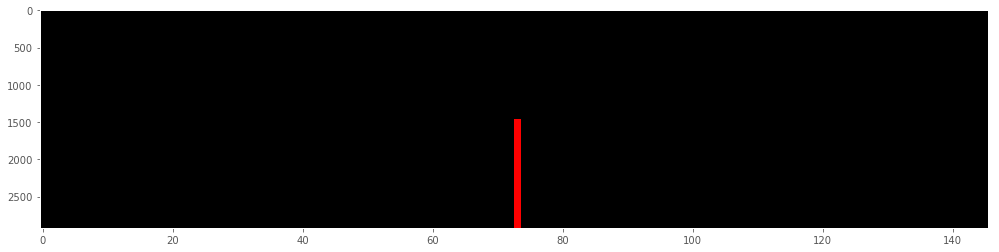

Features with Nans: 0


In [20]:
###Check missing values
###Prepare datadataCorrFeaturesfor visualize missing values
dataHeatMap= dataCorrFeatures.copy()
table = np.ones((dataHeatMap.shape[0], dataHeatMap.shape[1], 3), dtype=np.uint8) * 0

col= dataHeatMap.columns
for i in range(0, len(col)):
    dataHeatMap.loc[~dataHeatMap[col[i]].isnull(), col[i]]=0
dataHeatMap= dataHeatMap.fillna(255)
dataHeatMap= dataHeatMap.values.tolist()

for i in range(0, len(dataHeatMap)):
    table[i, :, 0]= dataHeatMap[i]
    
style.use('ggplot')
f = plt.figure(figsize=(17, 4))
plt.imshow(table, interpolation='none', aspect='auto')
#plt.xticks(range(table.shape[1]), data.columns, rotation='vertical')
plt.grid(False)
plt.show()
print("Features with Nans: " + str(data.drop("SalePrice", axis=1).isnull().values.sum()))

Print all features with correlation > 0.3

In [21]:
###Features with the best correlation to SalePrice
train= dataCorrFeatures[~dataCorrFeatures.SalePrice.isnull()]
test= dataCorrFeatures[dataCorrFeatures.SalePrice.isnull()]
testId= test.Id
tCorr= train.corr().abs()
tCorr[tCorr.index=="SalePrice"][tCorr.abs()>0.3].dropna(axis=1)

,SalePrice,TotalArea,OverallQual,GrLivArea,GarageCars,TotalRooms,GarageArea,TotalBsmtSF,TotalBath,1stFlrSF,FullBath,TotRmsAbvGrd,Age,YearBuilt,YearsSinceRemodel,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,GarageYrBlt,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,1stFlrSF2,1stFlrSF3,1stFlrSFSqrt,2ndFlrSF2,2ndFlrSF3,Age2,Age3,AgeSqrt
SalePrice,1.0,0.806869,0.790982,0.708624,0.640409,0.629535,0.623431,0.613581,0.613005,0.605852,0.560664,0.533723,0.522897,0.522897,0.509079,0.507101,0.472614,0.466929,0.38642,0.382109,0.334544,0.324413,0.319334,0.315856,0.54899,0.390216,0.604617,0.432726,0.476422,0.406107,0.307943,0.567673


Check for the skeweness.

Log transform of the skewed numerical features to lessen impact of outliers

In [22]:
### Check skewenss
skewed = dataCorrFeatures[numeric].apply(lambda x: skew(x.dropna().astype(float)))
data2= dataCorrFeatures.copy()
skewdCols= [x for x in skewed.index if (x not in ["Id", "SalePrice"])]
print("Number of skewed columns >0.5: "+ str(len(skewdCols)))
skewed= skewed[skewdCols]
skewdValue= 0.5
data2[skewed[skewed.abs()>skewdValue].index]= np.log1p(data2[skewed[skewed.abs()>skewdValue].index])

train= data2[~data2.SalePrice.isnull()]
test= data2[data2.SalePrice.isnull()]

corr2= tCorr.copy()
hh= corr2.columns
k= []
for i in range(0, len(hh)):
    if not sum(((corr2[corr2.index!=hh[i]][hh[i]]<0.5)==0)*1):
        k.extend([hh[i]])

#train= train[train.SalePrice< train.SalePrice.quantile(.99)]
features= data2.columns.drop("SalePrice")
###check Nans in features train
for i in features:
    tt= train[train[i].isnull()]
    if len(tt)>0:
        print (i)
        train[i]=train[i].fillna(train[i].median())
        
###check Nans in features test
for i in features:
    tt= test[test[i].isnull()]
    if len(tt)>0:
        print (i)
        test[i]=test[i].fillna(test[i].median())
        
dataCorrFeaturesUnSkew= pd.concat([train, test], axis=0)

Number of skewed columns >0.5: 41


Create dummy features for categorical values 

In [23]:
###Create dummy varibles for categorical features
cat= np.intersect1d(dataCorrFeaturesUnSkew.columns, categorical)
dataCat= dataCorrFeaturesUnSkew[categorical]
dataCat = pd.get_dummies(dataCat)
dataNew= pd.concat([dataCorrFeaturesUnSkew, dataCat], axis=1)

In [24]:
train= dataNew[~dataNew.SalePrice.isnull()]
y= train.SalePrice
train= train.drop("SalePrice", axis=1)
test= dataNew[dataNew.SalePrice.isnull()]
test= test.drop("SalePrice", axis=1)
testId= test.Id
train= train.drop("Id", axis=1)
test= test.drop("Id", axis=1)


In [25]:
print("Train " +str(train.shape))
print ("Test " +str(test.shape))

Train (1460, 485)
Test (1459, 485)


In [26]:
tt= dataNew.drop("SalePrice", axis=1)
tt[tt.isnull().any(axis=1)]

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition,IsGarage,IsRegularLotShape,IsAlley,IsMSZoningRL,IsLandSlopeGtl,Remodeled,RecentRemodel,IsBsmtCondTa,IsBsmtFinType2Unf,IsHeatingGasA,VeryNewHouse,IsFireplaces,IsPavedDrivePaved,HasWoodDeck,Hs2Floor,SoldAtYrBuild,IsBath,IsCars,Is2ndFloor,IsMasVnr,IsWoodDeck,IsOpenPorch,IsEnclosedPorch,Is3SsnPorch,IsScreenPorch,GarageOld,HouseOld,NeighborhoodBin,TotalArea,OverallQual,GrLivArea,GarageCars,TotalRooms,GarageArea,TotalBsmtSF,TotalBath,1stFlrSF,FullBath,TotRmsAbvGrd,Age,YearBuilt,YearsSinceRemodel,YearRemodAdd,MasVnrArea,Fireplaces,BsmtFinSF1,GarageYrBlt,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,KitchenAbvGr,EnclosedPorch,ScreenPorch,PoolArea,MSSubClass,OverallCond,3SsnPorch,SeasonSold,LowQualFinSF,HighSeason,Id,MiscVal,BsmtHalfBath,BsmtFinSF2,1stFlrSF2,1stFlrSF3,1stFlrSFSqrt,2ndFlrSF2,2ndFlrSF3,2ndFlrSFSqrt,3SsnPorch2,3SsnPorch3,3SsnPorchSqrt,Age2,Age3,AgeSqrt,BedroomAbvGr2,BedroomAbvGr3,BedroomAbvGrSqrt,BsmtFinSF12,BsmtFinSF13,BsmtFinSF1Sqrt,BsmtFinSF22,BsmtFinSF23,BsmtFinSF2Sqrt,BsmtFullBath2,BsmtFullBath3,BsmtFullBathSqrt,BsmtHalfBath2,BsmtHalfBath3,BsmtHalfBathSqrt,BsmtUnfSF2,BsmtUnfSF3,BsmtUnfSFSqrt,MSZoning_0,MSZoning_1,MSZoning_2,MSZoning_3,MSZoning_4,Street_0,Street_1,Alley_0,Alley_1,Alley_2,LotShape_0,LotShape_1,LotShape_2,LotShape_3,LandContour_0,LandContour_1,LandContour_2,LandContour_3,Utilities_0,Utilities_1,Utilities_2,LotConfig_0,LotConfig_1,LotConfig_2,LotConfig_3,LotConfig_4,LandSlope_0,LandSlope_1,LandSlope_2,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13,Neighborhood_14,Neighborhood_15,Neighborhood_16,Neighborhood_17,Neighborhood_18,Neighborhood_19,Neighborhood_20,Neighborhood_21,Neighborhood_22,Neighborhood_23,Neighborhood_24,Condition1_0,Condition1_1,Condition1_2,Condition1_3,Condition1_4,Condition1_5,Condition1_6,Condition1_7,Condition1_8,Condition2_0,Condition2_1,Condition2_2,Condition2_3,Condition2_4,Condition2_5,Condition2_6,Condition2_7,BldgType_0,BldgType_1,BldgType_2,BldgType_3,BldgType_4,HouseStyle_0,HouseStyle_1,HouseStyle_2,HouseStyle_3,HouseStyle_4,HouseStyle_5,HouseStyle_6,HouseStyle_7,RoofStyle_0,RoofStyle_1,RoofStyle_2,RoofStyle_3,RoofStyle_4,RoofStyle_5,RoofMatl_0,RoofMatl_1,RoofMatl_2,RoofMatl_3,RoofMatl_4,RoofMatl_5,RoofMatl_6,RoofMatl_7,Exterior1st_0,Exterior1st_1,Exterior1st_2,Exterior1st_3,Exterior1st_4,Exterior1st_5,Exterior1st_6,Exterior1st_7,Exterior1st_8,Exterior1st_9,Exterior1st_10,Exterior1st_11,Exterior1st_12,Exterior1st_13,Exterior1st_14,Exterior2nd_0,Exterior2nd_1,Exterior2nd_2,Exterior2nd_3,Exterior2nd_4,Exterior2nd_5,Exterior2nd_6,Exterior2nd_7,Exterior2nd_8,Exterior2nd_9,Exterior2nd_10,Exterior2nd_11,Exterior2nd_12,Exterior2nd_13,Exterior2nd_14,Exterior2nd_15,MasVnrType_0,MasVnrType_1,MasVnrType_2,MasVnrType_3,ExterQual_0,ExterQual_1,ExterQual_2,ExterQual_3,ExterCond_0,ExterCond_1,ExterCond_2,ExterCond_3,ExterCond_4,Foundation_0,Foundation_1,Foundation_2,Foundation_3,Foundation_4,Foundation_5,BsmtQual_0,BsmtQual_1,BsmtQual_2,BsmtQual_3,BsmtQual_4,BsmtCond_0,BsmtCond_1,BsmtCond_2,BsmtCond_3,BsmtCond_4,BsmtExposure_0,BsmtExposure_1,BsmtExposure_2,BsmtExposure_3,BsmtExposure_4,BsmtFinType1_0,BsmtFinType1_1,BsmtFinType1_2,BsmtFinType1_3,BsmtFinType1_4,BsmtFinType1_5,BsmtFinType1_6,BsmtFinType2_0,BsmtFinType2_1,BsmtFinType2_2,BsmtFinType2_3,BsmtFinType2_4,BsmtFinType2_5,BsmtFinType2_6,Heating_0,Heating_1,Heating_

In [27]:
stdSc = StandardScaler()
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

Partition the dataset in train and validation sets.

Use random forest for x_train and apply it on x_test? and check how it works.

In [28]:
###Apply RandomForest

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.3, random_state=0)
rf = RandomForestRegressor(n_jobs = 1)
rf.fit(X_train, y_train)
pred= rf.predict(X_test)

#train2= X_test.copy()
#train2["SalePrice"]= y_test
#train2["Pred"]= pred

print ("RMSE: " + str(rmse(np.log(y_test), np.log(pred))))
print ("MSE: " + str(Error(y_test, pred)))

print ("R2 train: " + str(rf.score(X_train, y_train)))
print ("R2 test: " + str(rf.score(X_test, y_test)))

print ("Features used: "+ str(train.shape[1]))

#print("RMSE on Training set :", rmse_cv_train(rf).mean())
#print("RMSE on Test set :", rmse_cv_test(rf).mean())

RMSE: 0.14333434167
MSE: 0.10243863810626228
R2 train: 0.967242521615
R2 test: 0.843720177083
Features used: 485


In [29]:
### Feature importance top 30
from tabulate import tabulate
headers = ["name", "score"]
values = sorted(zip(X_train.columns, rf.feature_importances_), key=lambda x: x[1] * -1)
importance = pd.DataFrame(values)
importance.columns= ["Feature", "Value"]
#print(tabulate(values, headers, tablefmt="plain"))


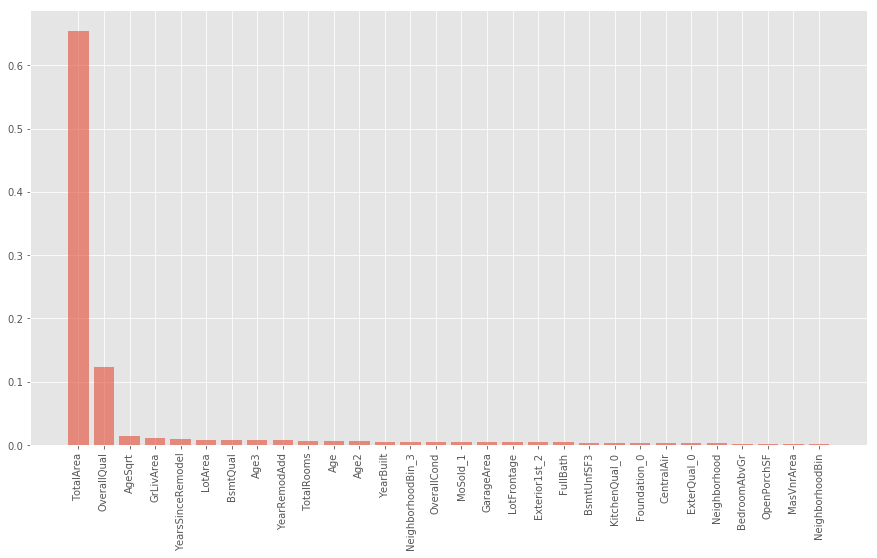

In [30]:
importance2= importance.head(30)
x= range(0, len(importance2.Feature))
plt.figure(figsize=(15, 8))
plt.subplot(111)
plt.bar(x, importance2.Value, align='center', alpha=0.6)
plt.xticks(x, importance2.Feature,  rotation='vertical')
plt.show()

Use fitted model to predict test test.

In [31]:
###Predict test set

useFeatures= importance.Feature.iloc[:300]
rf = RandomForestRegressor(n_jobs = 2, n_estimators=300)
rf.fit(train[useFeatures], y)
pred= rf.predict(test[useFeatures])

print ("R2 train: " + str(rf.score(train[useFeatures], y)))

testFinal= test.copy()
testFinal["SalePrice"]= pred
testFinal["Id"]= testId

testFinal[["Id", "SalePrice"]].to_csv("TestPrediction.csv", index=False)


#check= X_test.copy()
#check["TruPrice"]= y_test
#check["PredPrice"]= pred
#check["Id"]= range(0, len(check))


#plt.scatter(check.Id, check.TruPrice, c="g", alpha=0.7, s=5)
#plt.scatter(check.Id, check.PredPrice, c="b", alpha=0.7, s=5)
#plt.grid(True)


#plt.scatter(train.index, train.SalePrice, c="g", alpha=0.7, s=5)
#plt.grid(True)

#train.SalePrice.quantile(.99)

R2 train: 0.983465132439


In [32]:
'''
import xgboost as xgb

regr = xgb.XGBRegressor(
                 colsample_bytree=0.2,
                 gamma=0.0,
                 learning_rate=0.01,
                 max_depth=4,
                 min_child_weight=1.5,
                 n_estimators=7200,                                                                  
                 reg_alpha=0.9,
                 reg_lambda=0.6,
                 subsample=0.2,
                 seed=42,
                 silent=1)

regr.fit(train, y)

# Run prediction on training set to get a rough idea of how well it does.
y_pred = regr.predict(train)
y_test = y
print("XGBoost score on training set: ", rmse(y_test, y_pred))

# Run prediction on the Kaggle test set.
y_pred_xgb = regr.predict(test)


test["SalePrice"]= pred
test["Id"]= testId

test[["Id", "SalePrice"]].to_csv("TestPredictionGboost.csv", index=False)
'''

'\nimport xgboost as xgb\n\nregr = xgb.XGBRegressor(\n                 colsample_bytree=0.2,\n                 gamma=0.0,\n                 learning_rate=0.01,\n                 max_depth=4,\n                 min_child_weight=1.5,\n                 n_estimators=7200,                                                                  \n                 reg_alpha=0.9,\n                 reg_lambda=0.6,\n                 subsample=0.2,\n                 seed=42,\n                 silent=1)\n\nregr.fit(train, y)\n\n# Run prediction on training set to get a rough idea of how well it does.\ny_pred = regr.predict(train)\ny_test = y\nprint("XGBoost score on training set: ", rmse(y_test, y_pred))\n\n# Run prediction on the Kaggle test set.\ny_pred_xgb = regr.predict(test)\n\n\ntest["SalePrice"]= pred\ntest["Id"]= testId\n\ntest[["Id", "SalePrice"]].to_csv("TestPredictionGboost.csv", index=False)\n'